In [1]:
import collections
import csv
import glob
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import random


from COCOWrapper import COCOWrapper


In [2]:
base_location = '/home/gregory/Datasets/OpenImages'

model_types = ['initial-tune', 'random-tune-paint']

main_list = [['Handbag'], ['Cricket ball', 'Football', 'Golfball', 'Rugby ball', 'Tennis ball'], ['Knife'], ['Flying disc'], ['Skateboard'], ['Snowboard'], ['Wine glass'], ['Tennis racket'], ['Remote control'], ['Ski'], ['Tie'], ['Toothbrush']]
name_list = ['handbag', 'sports-ball', 'knife', 'frisbee', 'skateboard', 'snowboard', 'wine-glass', 'tennis-racket', 'remote', 'skis', 'tie', 'toothbrush']


In [3]:
# Setup COCO

coco = COCOWrapper()


loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [4]:
# Setup Open Images

reader = csv.reader(open('{}/classes.csv'.format(base_location)))
name_to_class = {}
class_to_name = {}
for row in reader:
    name_to_class[row[1]] = row[0]
    class_to_name[row[0]] = row[1]
    
class_to_images = collections.defaultdict(lambda: collections.defaultdict(lambda: set()))
all_images = collections.defaultdict(lambda: set())
for d in ['validation', 'test']:
    reader = csv.DictReader(open('{}/{}-annotations-bbox.csv'.format(base_location, d)))
    for line in reader:
        all_images[d].add(line['ImageID'])
        class_to_images[d][class_to_name[line['LabelName']]].add(line['ImageID'])
        
def get_sets(dataset, labels0, labels1):
    # returns four sets:
    # (a & b), (a & not b), (not a & b), (not a & not b)
    with0 = set()
    with1 = set()
    for p in labels0:
        with0 = with0.union(class_to_images[dataset][p])
    for p in labels1:
        with1 = with1.union(class_to_images[dataset][p])
    both = with0.intersection(with1)
    anotb = with0.difference(with1)
    bnota = with1.difference(with0)
    neither = all_images[dataset].difference(with0.union(with1))
    return both, anotb, bnota, neither

In [5]:
# Spurious class is Person
spurious = [x for x in class_to_images['validation'].keys() if 'human' in x.lower() or x.lower() in ['man', 'woman', 'person']]




handbag
Both - 42 Just Spurious - 35507 Just main - 156 Neither - 76489


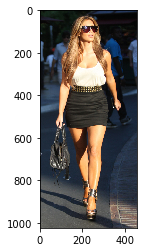

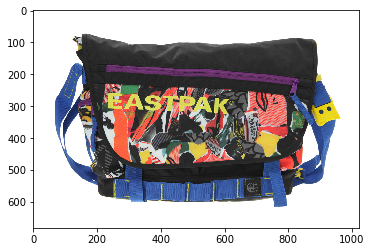

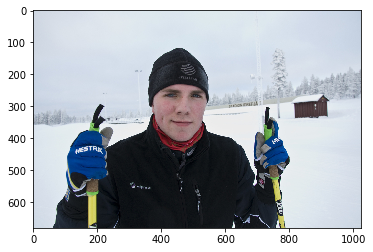



sports ball
Both - 225 Just Spurious - 35324 Just main - 74 Neither - 76571


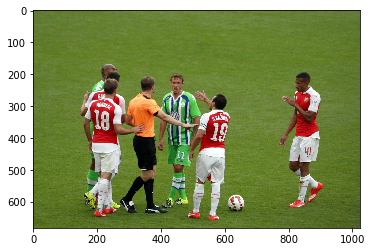

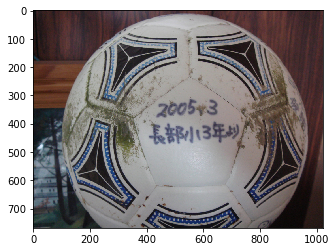

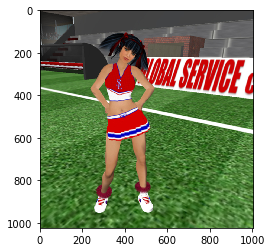



knife
Both - 2 Just Spurious - 35547 Just main - 165 Neither - 76480


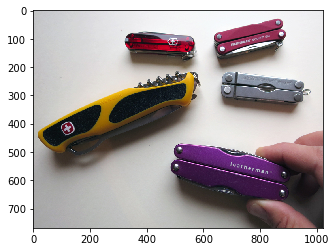

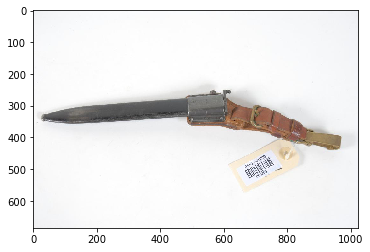

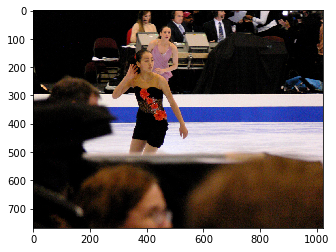



frisbee
Both - 2 Just Spurious - 35547 Just main - 1 Neither - 76644


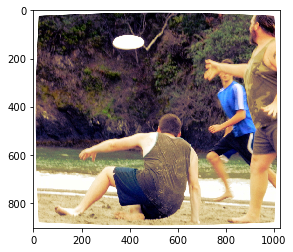

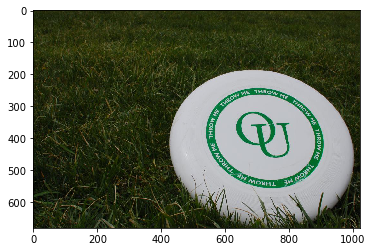

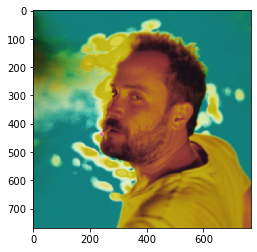



skateboard
Both - 136 Just Spurious - 35413 Just main - 4 Neither - 76641


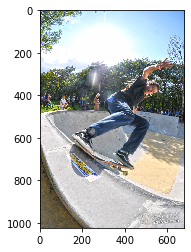

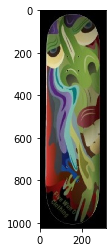

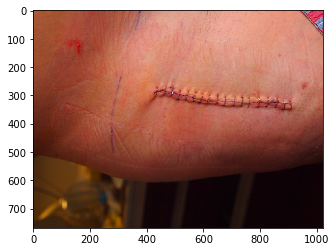



snowboard
Both - 43 Just Spurious - 35506 Just main - 0 Neither - 76645


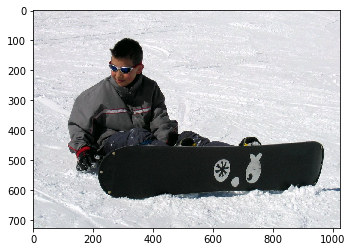

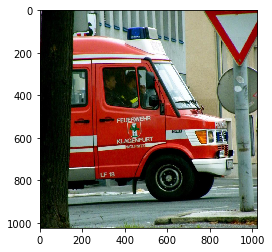



wine glass
Both - 68 Just Spurious - 35481 Just main - 193 Neither - 76452


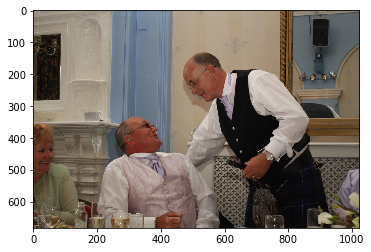

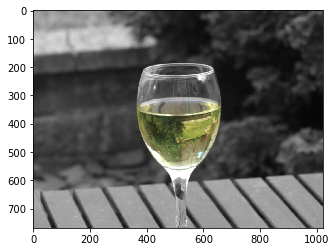

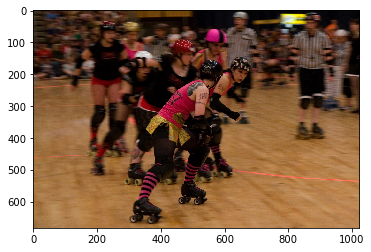



tennis racket
Both - 93 Just Spurious - 35456 Just main - 11 Neither - 76634


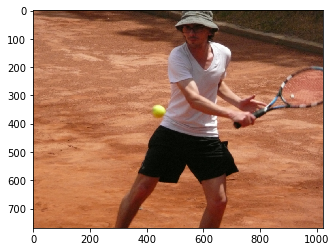

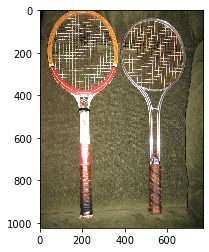

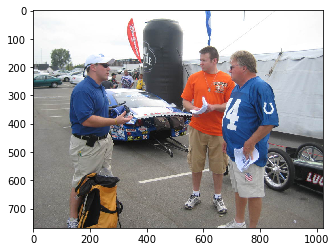



remote
Both - 0 Just Spurious - 35549 Just main - 20 Neither - 76625


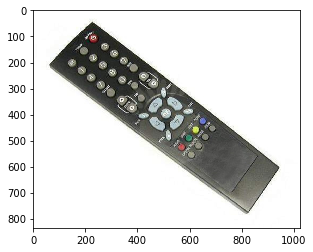

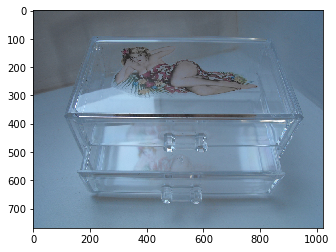



skis
Both - 132 Just Spurious - 35417 Just main - 5 Neither - 76640


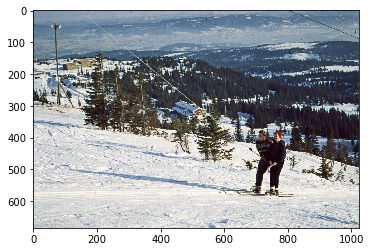

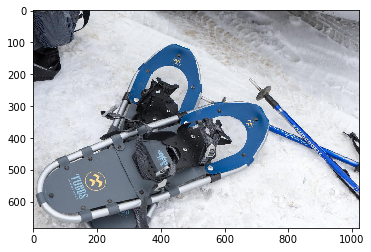

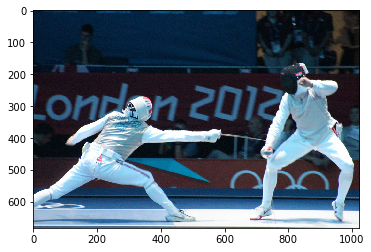



tie
Both - 302 Just Spurious - 35247 Just main - 18 Neither - 76627


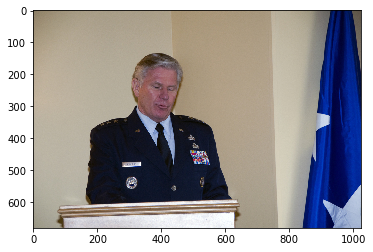

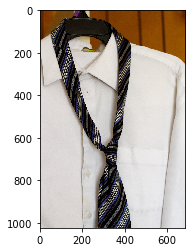

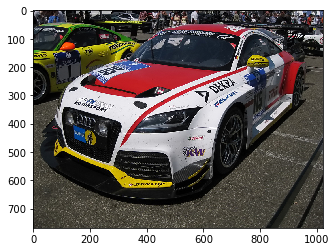



toothbrush
Both - 0 Just Spurious - 35549 Just main - 12 Neither - 76633


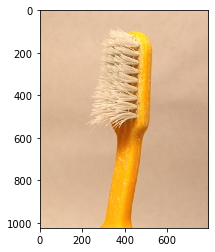

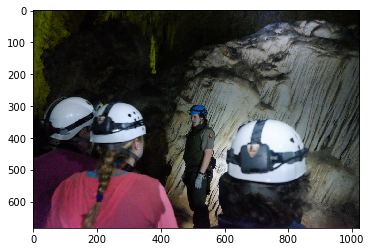

In [6]:

for i in range(len(main_list)):

    main = main_list[i]
    main_class = name_list[i].replace('-', ' ')

    # Get the image split
    both = []
    anotb = []
    bnota = []
    neither = []
    for dataset in ['test']:

        both_tmp, anotb_tmp, bnota_tmp, neither_tmp = get_sets(dataset, spurious, main)

        for f in both_tmp:
            both.append(f)
            
        for f in anotb_tmp:
            anotb.append(f)
            
        for f in bnota_tmp:
            bnota.append(f)
            
        for f in neither_tmp:
            neither.append(f)
            
    print()
    print()
    print(main_class)
    print('Both -', len(both), 'Just Spurious -', len(anotb), 'Just main -', len(bnota), 'Neither -', len(neither))
     
    if len(both) > 0:
        plt.imshow(Image.open('{}/test/{}.jpg'.format(base_location, random.choice(both))))
        plt.show()
        plt.close()
    
    if len(bnota) > 0:
        plt.imshow(Image.open('{}/test/{}.jpg'.format(base_location, random.choice(bnota))))
        plt.show()
        plt.close()
    
    if len(anotb) > 0:
        plt.imshow(Image.open('{}/test/{}.jpg'.format(base_location, random.choice(anotb))))
        plt.show()
        plt.close()
    

In [ ]:
def get_counts(filenames, model_type, index):
    avg = 0.0
    avg_count = 0
    for pred_file in glob.glob('./Models/{}/*_OpenImages.p'.format(model_type)):
        preds = pickle.load(open(pred_file, 'rb'))
        count = 0
        for filename in filenames:
            if preds[filename][index] == 1:
                count += 1
        avg += count
        avg_count += 1
    return avg / avg_count

for i in range(len(main_list)):

    main = main_list[i]
    main_class = name_list[i].replace('-', ' ')

    # Get the image split
    both = []
    anotb = []
    bnota = []
    neither = []
    for dataset in ['validation', 'test']:

        both_tmp, anotb_tmp, bnota_tmp, neither_tmp = get_sets(dataset, spurious, main)

        for f in both_tmp:
            both.append(f)
            
        for f in anotb_tmp:
            anotb.append(f)
            
        for f in bnota_tmp:
            bnota.append(f)
            
        for f in neither_tmp:
            neither.append(f)
    
    print()
    print()
    print(main_class)
    print('Both -', len(both), 'Just Spurious -', len(anotb), 'Just main -', len(bnota), 'Neither -', len(neither))

    if len(both) > 10 and len(bnota) > 10:
        # Start aggregating the model's performance
        index = coco.get_cat_ids(main_class)[0]
        for model_type in model_types:
            both_count = get_counts(both, model_type, index)
            anotb_count = get_counts(anotb, model_type, index)
            bnota_count = get_counts(bnota, model_type, index)
            neither_count = get_counts(neither, model_type, index)
            
            print(anotb_count)

            p_with_a = both_count / (both_count + anotb_count)
            p_without_a = bnota_count / (bnota_count + neither_count)

            r_with_a = both_count / len(both)
            r_without_a = bnota_count / len(bnota)
            
            f1_with_a = 2 * p_with_a * r_with_a / (p_with_a + r_with_a)
            f1_without_a = 2 * p_without_a * r_without_a / (p_without_a + r_without_a)
            
            print()
            print(model_type, ': Metric without Spurious, Metric with Spurious, Change in Metric')
            print('Precision: ', p_without_a, p_with_a, p_without_a - p_with_a)
            print('Recall: ', r_without_a, r_with_a, r_without_a - r_with_a)
            print('F1: ', f1_without_a, f1_with_a, f1_without_a - f1_with_a)
        
        